# Nyquist Stability

TODO: Redraw diagrams using Python code.

By the end of this notebook, you should be able to:

- [TODO Insert Learning Goals]

In [240]:
# import libraries we need later
%matplotlib inline
import control
import numpy as np
import matplotlib.pyplot as plt

Nyquist plots and stability is an important topic in classical control, which is usually taught as a "bonus" section in undergraduate CHBE control courses. However, it is part of the regular curriculum in MECH/ECE undergrad control, so I consider it necessary to cover it here also in CHBE, at least for those who wish to have a strong background in control.

To motivate the use of Nyquist, here are some of its strengths over other methods:

- Computationally inexpensive to generate contours vs. root finding or solving Routh-Hurwitz arrays
- Contours and clockwise-encirclements are easy to visualize with fairly little practice
- Closed-loop stability can be determined regardless of multiple critical (phase cross-over) frequencies, or in the presence of RHP poles in L(s), two cases in which Bode may fail to provide the correct stability conclusions

With that, let's look at the well-known, dreaded -1 point and see how it relates to closed-loop instability:

![](../../assets/nyquist/negative_one.png)

In [241]:
# TODO replace diagram

Above is an empty Nyquist plot with the blue line representing the imaginary axis, and the red arrow representing a vector from the origin to the point $-1$. Suppose that this vector represents a certain open-loop TF, $L(s)$, at some specific frequency $\omega$. Using simple geometry, we can determine its magnitude and phase as $\lvert L(j \omega) \rvert = 1 = 0dB$ and $\angle L(j \omega) = -180^o$, respectively.

Recall from Bode that this combination implies $L$ is at its ultimate gain, or at the point of marginal stability. In other words, if any slight extra gain or delay is introduced to $L$, the closed-loop would become unstable. Equivalently, at this $-1$ point, the closed-loop TF $\big( \frac{L}{1+L} \big)$ has a pair of poles located at $\pm j \omega_{180}$, which again implies marginal stability. In light of these realizations, as control engineers we strive to stay as far away from the $-1$ point as possible, so as to allow ourselves comfortably large gain and phase margins when designing controllers for our systems.

However, at this point we still haven't justified mathematically why we're concerned with the point $-1$ (and not, for example, $-2$ or $-5$) and where the equation $Z = N + P$ comes from.

To do this, let's discuss the following 2 concepts:

## Contours 

Tracings or mappings of a rational expression on the complex plane, by cycling its argument (in this case frequency) between $- \infty$ and $+\infty$. For example, the expression $F(s) = \frac{1}{s+1}$ has the spectrum $F(j \omega) = \frac{1-j \omega}{1+\omega^2}$ which can be evaluated at the following frequencies:

| $\omega$ | $F(j\omega)$ |
|:-------------:|:---------------:|
| $-\infty$   | $0+0^+j$      |
| $-1$        | $0.5+0.5j$    |
| $0$         | $1+0j$        |
| $1$         | $0.5-0.5j$    |
| $\infty$    | $0+0^-j$      |
| <img width=50/> | <img width=100/> |

*Note: Take a look at the Markdown code for the table above. The hidden `<img width=200/>` in the last row is a [cool trick](https://stackoverflow.com/questions/36121672/set-table-column-width-via-markdown) to size the table.*

Knowing these points, the contour of F can be traced, and software such as MATLAB can do this relatively quickly:

![](../../assets/nyquist/f_contour.png)

We can also do this easily in Python:

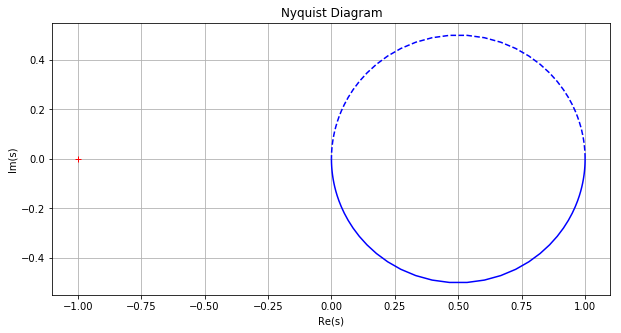

In [242]:
# Set up the plot parameters
plt.figure(figsize=(10,5))
plt.grid(True)
plt.title('Nyquist Diagram')
plt.xlabel('Re(s)')
plt.ylabel('Im(s)')

# Nyquist plot
sys = control.tf(1,[1,1])
omega = np.logspace(-3,3,100)
real_arr, imag_arr, freq_arr = control.nyquist_plot(sys,omega)

And even create animations for it!

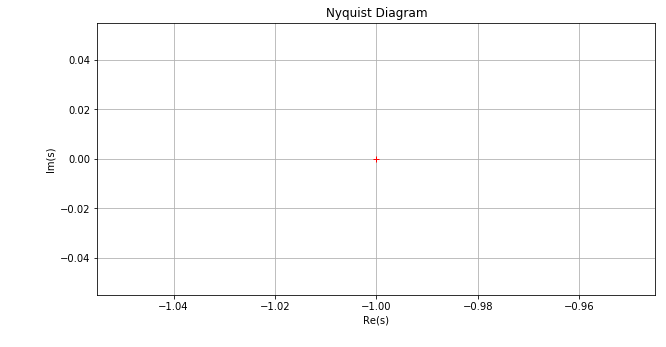

In [243]:
# https://stackoverflow.com/questions/49722298/drawing-a-nyquist-diagram-animation-on-python
from matplotlib import animation
from IPython.display import HTML
from matplotlib.patches import Arrow

# Set up figure params
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.grid(True)
ax.set_title('Nyquist Diagram')
ax.set_xlabel('Re(s)')
ax.set_ylabel('Im(s)')

# Our Nyquist data
realData, imagData, mirrorImagData = [], [], []
actual_line, = ax.plot([], [], 'b', animated=True)
mirror_line, = ax.plot([], [], '--b', animated=True)
actual_arrow = ax.annotate('', xy = (0,0), 
                        xytext = (0,0),
                        size=15,
                        arrowprops = {'arrowstyle': "->"})
mirror_arrow = ax.annotate('', xy = (0,0), 
                        xytext = (0,0),
                        size=15,
                        arrowprops = {'arrowstyle': "->"})

# Mark the -1 point
ax.plot([-1], [0], 'r+')

# Flip the data to start plotting from the origin
real = real_arr[::-1]
imag = imag_arr[::-1]

def init():
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-0.55, 0.55)
    return line,

def animate(i):
    mirror = np.negative(imag)
    realData.append(real[i])
    imagData.append(imag[i])
    mirrorImagData.append(mirror[i])
    
    # plot the actual line
    actual_line.set_data(realData, imagData)
    actual_arrow.set_position((real[i],imag[i]))
    
    # plot the mirror image
    mirror_line.set_data(realData, mirrorImagData)
    mirror_arrow.set_position((real[i],mirror[i]))
        
    # This is a crude way to handle the last data point
    if i < len(real)-1:
        actual_arrow.xy = (real[i+1],imag[i+1])
        mirror_arrow.xy = (real[i+1],mirror[i+1])
    else:
        actual_arrow.xy = (real[i],imag[i])
        mirror_arrow.xy = (real[i],mirror[i])
            
    
    # Print out the current frame using "\r", the 'carriage return' character, as our end character.
    # This makes Python print the frame on the same line.
    print("Frame: {:0d}".format(i), end="\r")
    return (actual_line,mirror_line,actual_arrow,mirror_arrow)

** Note: Notice in the code above that we reverse the `real` and `imag` arrays by slicing it with `[::-1]` to start plotting from the origin **

In [244]:
# blit=True will only draw the parts that have changed.
# The `interval` parameter is the delay between frames in milliseconds and it controls the speed of the animation.
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=range(len(real)), interval=40, blit=True)
HTML(anim.to_jshtml())

We can take any rational transfer function and apply the previous procedure to sketch its contour. Knowing this, let's move on to the next important concept, which explains the reason behind the $-1$ point as well as the $Z = N+P$ equation.

## Cauchy's argument principle

The contour of any rational expression will encircle the _origin_ once in a clockwise fashion, **for each additional RHP-zero it has compared to RHP-poles**. Mathematically, this is expressed as:

$$ N = Z - P $$

where $N$ is the number of clockwise encirclements the contour makes about the origin, $Z$ the number of RHP-zeroes in $F$, and $P$ the number of RHP-poles in $F$. This may look confusing, so let's go through several examples as exercise:

1. $F(s)=\frac{s-1}{s+1}$: $N=Z-P=1-0=1$, So we expect its contour to encircle the origin once clockwise. Indeed, this is confirmed by MATLAB:
                
![](../../assets/nyquist/f1.png)
                
2. $F(s)=\frac{(s-2)(s-3)}{(s-1)(s-4)}$: $N=Z-P=2-2=0$, so we expect no clockwise encirclements of the origin, which is again confirmed using MATLAB:
                
![](../../assets/nyquist/f2.png)

3. $F(s)=\frac{(s-15)(s-0.8)}{(s+1.1)(s+4.7)}$: $N=Z-P=2-0=2$, so we expect two clockwise encirclements of the origin:
            
![](../../assets/nyquist/f3.png)
            
4. $F(s)=\frac{s+1}{(s-2)(s-3)}$: $N=Z-P=0-2=-2$; since $N$ is negative, we expect two \textit{counterclockwise} encirclements of the origin, which is again confirmed:
                
![](../../assets/nyquist/f4.png)

So Cauchy's argument principle turns out to be pretty straightforward: it tells us **how many more RHP-zeroes than RHP-poles a TF has**. 

## Proof for Nyquist Stability

But so far we've discussed encirclements about the **origin**; how does this translate to the well-known $-1$ point in Nyquist stability? Usually profound realizations (or proofs) are made by connecting a series of trivial statements, and this is no exception.

Consider the following equivalent statements:

1. The closed-loop is unstable if the TF $\big( \frac{L}{1+L} \big)$ has at least one RHP-pole.
2. If the TF $\big( \frac{L}{1+L} \big)$ has at least one RHP-pole, then the TF $(1+L)$ has at least one RHP-zero.
3. If the TF $(1+L)$ has at least one RHP-zero, then its contour will encircle the origin at least once clockwise, according to \textbf{Cauchy's argument principle.}
4. The TF $L$ is equal to $(1+L)-1$. In other words, the contour of $L$ is the contour of $(1+L)$ shifted to the left by one unit, on the complex plane.
5. If the contour of $1+L$ encircles the origin at least once clockwise, \textbf{then the contour of $L$ will encircle the point $-1$ at least once clockwise.}

The final statement above completes the proof for Nyquist stability.

## Margins

As a last exercise, let's visually deduce the Gain and Phase Margins on a Nyquist plot, using our understanding from Bode and simple geometry:

![](../../assets/nyquist/margins.png)

In the previous figure, the black solid curve represents the contour of $L(j\omega)$. At the point **<font color='blue'>1</font>**, $\angle L(j\omega)=-180^o$, therefore the corresponding frequency is $\omega = \omega_{180}$. The length of the vector spanning from the origin to the point **<font color='blue'>1</font>** is $\lvert L(j\omega_{180})\rvert$, which is the **inverse of the Gain Margin**.

On the other hand, the point **<font color='red'>2</font>** is the intersection between the contour of $L(j\omega)$ and the unit circle, so $\lvert L(j\omega)\rvert = 1$ here, therefore the corresponding frequency is $\omega=\omega_{0dB}$. The **Phase Margin** is therefore the difference between the phase at this point and $-180^o$, i.e. $\angle L(j\omega_{0dB})-(-180^o)$.

From the figure above, we can see that both the Gain and Phase Margins can be geometrically interpreted as ``distances" from the $-1$ point, which we try to stay as far away from as possible.

## References

- Notes written by Yiting Tsai (Sept 2018)